In [1]:
import os

os.chdir('../../../')

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1129)>


False

In [5]:
fake_df = pd.read_csv(r'./projects/News Prediction/data/Fake.csv')
real_df = pd.read_csv(r'./projects/News Prediction/data/True.csv')

In [6]:
fake_df = fake_df[['title', 'text']]
real_df = real_df[['title', 'text']]

fake_df['class'] = 1
real_df['class'] = 0

In [7]:
df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
df.head()

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1


In [8]:
df['title_text'] = df['title'] + ' ' + df['text']
df.drop(['title', 'text'], axis=1, inplace=True)
df.head()

,class,title_text
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...


In [9]:
import re

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

def normalize(i):
#     for i in data:
    i = re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",i)
    
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)

    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [10]:
df['title_text'] = df['title_text'].apply(remove_stopwords)
df['title_text'] = df['title_text'].apply(normalize)

df.tail()

,class,title_text
44893,0,fully committed nato backs new us approach afg...
44894,0,lexisnexis withdrew two products chinese marke...
44895,0,minsk cultural hub becomes authorities minsk r...
44896,0,vatican upbeat possibility pope francis visiti...
44897,0,indonesia buy 114 billion worth russian jets j...


In [11]:
from sklearn.model_selection import train_test_split

X = df['title_text']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Build Model

In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers

dropout1 = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout1)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=METRICS)

# Training 

In [19]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=500, shuffle=True, callbacks=[early_stop])

Epoch 1/10
68/68 [==============================] - 6711s 99s/step - loss: 0.7610 - accuracy: 0.5208 - precision: 0.5250 - recall: 0.8799 - val_loss: 0.6814 - val_accuracy: 0.5470 - val_precision: 0.5396 - val_recall: 0.9114
Epoch 2/10
68/68 [==============================] - 6711s 99s/step - loss: 0.6872 - accuracy: 0.5506 - precision: 0.5609 - recall: 0.6480 - val_loss: 0.6598 - val_accuracy: 0.6156 - val_precision: 0.6022 - val_recall: 0.7806
Epoch 3/10
68/68 [==============================] - 6664s 98s/step - loss: 0.6696 - accuracy: 0.5833 - precision: 0.5903 - recall: 0.6642 - val_loss: 0.6435 - val_accuracy: 0.6492 - val_precision: 0.6436 - val_recall: 0.7377
Epoch 4/10
68/68 [==============================] - 6674s 98s/step - loss: 0.6532 - accuracy: 0.6138 - precision: 0.6210 - recall: 0.6710 - val_loss: 0.6289 - val_accuracy: 0.6710 - val_precision: 0.6654 - val_recall: 0.7464
Epoch 5/10
68/68 [==============================] - 6687s 99s/step - loss: 0.6406 - accuracy: 0.6312

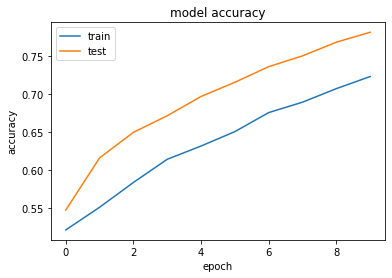

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

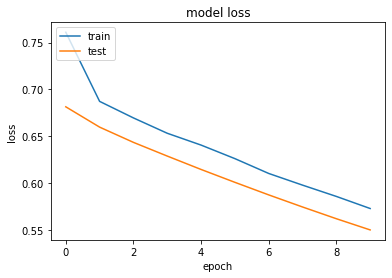

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evalulate

In [22]:
model.evaluate(X_test, y_test)

351/351 [==============================] - 1988s 6s/step - loss: 0.5501 - accuracy: 0.7808 - precision: 0.7730 - recall: 0.8225


[0.5501327514648438, 0.7808462977409363, 0.7730110287666321, 0.822517454624176]

In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

351/351 [==============================] - 1828s 5s/step
---Test Set Results---
Accuracy: 0.7808463251670379
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      5354
           1       0.77      0.82      0.80      5871

    accuracy                           0.78     11225
   macro avg       0.78      0.78      0.78     11225
weighted avg       0.78      0.78      0.78     11225



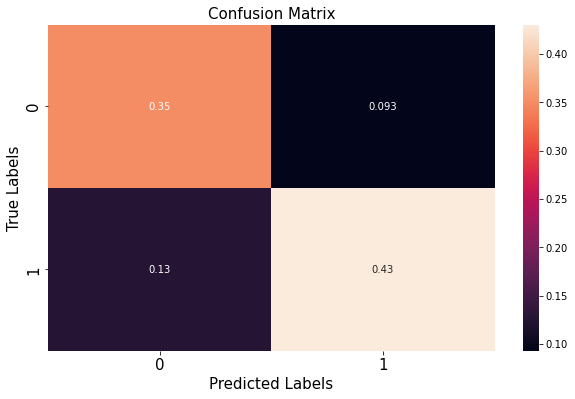

In [24]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

# Test

In [26]:
reviews = [
"Rift Between Officers and Residents as Killings Persist in South Bronx After the bullet shells get counted, the blood dries and the votive candles burn out, people peer down from   windows and see crime scenes gone cold: a band of yellow police tape blowing in the breeze. The South Bronx, just across the Harlem River from Manhattan and once shorthand for urban dysfunction, still suffers violence at levels long ago slashed in many other parts of New York City. And yet the city‚ efforts to fight it remain splintered, underfunded and burdened by scandal. In the 40th Precinct, at the southern tip of the Bronx, as in other poor, minority neighborhoods across the country, people long hounded for infractions are crying out for more protection against grievous injury or death. By September, four of every five shootings in the precinct this year were unsolved. Out of the city‚ 77 precincts, the 40th has the highest murder rate but the fewest detectives per violent crime, reflecting disparities in staffing that hit hardest in some neighborhoods outside Manhattan, according to a New York Times analysis of Police Department data. Investigators in the precinct are saddled with twice the number of cases the department recommends, even as their bosses are called to Police Headquarters to answer for the sharpest crime rise in the city this year. And across the Bronx, investigative resources are squeezed. It has the highest   rate of the city‚Äôs five boroughs but the thinnest detective staffing. Nine of the 14   precinct detective squads for violent crime in the city are there. The borough‚Äôs robbery squad is smaller than Manhattan‚Äôs, even though the Bronx has had 1, 300 more cases this year. And its homicide squad has one detective for every four murders, compared with one detective for roughly every two murders in Upper Manhattan and more than one detective per murder in Lower Manhattan. In   lobbies and   family apartments, outside methadone clinics and art studios, people take note of the inequity. They hear police commanders explain that they lack the resources to place a floodlight on a dangerous block or to post officers at a   corner. They watch witnesses cower behind   doors, more fearful of a gunman‚Äôs crew than confident in the Police Department‚Äôs ability to protect them. So though people see a lot, they rarely testify. And in the South Bronx, as in so many predominantly black and Hispanic neighborhoods like it in the United States, the contract between the police and the community is in tatters. Some people have stories of crime reports that were ignored, or 911 calls that went unanswered for hours. Others tell of a 911 call for help ending in the callers arrest, or of a minor charge leading to 12 hours in a fetid holding cell. This is the paradox of policing in the 40th Precinct. Its neighborhoods have historically been prime targets for aggressive tactics, like that are designed to ward off disorder. But precinct detectives there have less time than anywhere else in the city to answer for the blood spilled in violent crimes. Gola White, who was beside her daughter when she was shot and killed in a playground this summer, four years after her son was gunned down in the same housing project, ticked off the public safety resources that she said were scant in Bronx neighborhoods like hers: security cameras, lights, locks, investigating police officers. Here, we have nothing,she said. When it comes to  families, she said, the authorities really care as much. That‚Äôs how I feel. The Times has been documenting the murders logged this year in the 40th Precinct, one of a handful of neighborhoods where deadly violence remains a problem in an era of crime in New York City. The homicides  14 in the precinct this year, up from nine in 2015 strain detectives, and when they go unsolved, as half of them have this year, some look to take the law into their own hands. From hundreds of conversations with grieving relatives and friends, witnesses and police officers, the social forces that flare into murder in a place like the 40th Precinct become clearer: merciless gang codes, mental illness, drugs and long memories of feuds that simmered out of officers‚Äô view. The reasons some murders will never be solved also emerge: paralyzing fear of retribution, victims carrying secrets to their graves and relentless casework that forces detectives to move on in hopes that a break will come later. Frustrations build on all sides. Detectives‚Äô phones rarely ring with tips, and officers grow embittered with witnesses who will not cooperate. In the meantime, a victim‚Äôs friends conduct their own investigations, and talk of grabbing a stash gun from a wheel well or a mother‚Äôs apartment when they find their suspect. In the chasm between the police and the community, gangs and gun violence flourish. Parents try to protect their families from drug crews‚Äô threats, and officers work to overcome the residue of years of mistrust and understaffing in communities where they still go racing from one 911 call to the next. The streets around St. Mary‚Äôs Park were the scene of two fatal shootings logged in the 40th Precinct this year. Both are unsolved. James Fernandez heard talk of the murders through the door of his   apartment on East 146th Street in a     the Betances Houses. He lived at the end of a long hallway strewn with hypodermic needles, empty dope bags and discarded Hennessy bottles. A   young men who spoke of being in a subset of the Bloods gang had made it their drug market, slinging marijuana and cocaine to regulars, flashing firearms and blowing smoke into the Fernandez apartment. When Mr. Fernandez, 40, asked the young men to move, they answered by busting up his car. This kind of crime, an anachronism in much of New York, still rattles the 40th Precinct, even though murders there have fallen to 14 this year from 83 in 1991. It has more major felony crimes per resident than any other residential district in the city. It is also one of the poorest communities in the country, and many young men find their way into underground markets. Mr. Fernandez was not one to shrink from the threats. When he was growing up on the Lower East Side, he rode his bicycle around to the customers of the drug dealers he worked for and collected payments in a backpack. After leaving that life, he got a tech maintenance job and, three years ago, moved into the Betances Houses with his wife and daughter, now 11. He had two choices to get help with the drug crew: call the police for help and risk being labeled a snitch, or call his old Lower East Side bosses for muscle and risk violence. He chose the police. Again and again, he walked into a local substation, Police Service Area 7, and asked for protection. His daughter was using an inhaler to relieve coughs from the marijuana smoke. Mr. Fernandez and his wife got terrible headaches. ‚ÄúThere‚Äôs a lot of killers here, and we are going to kill you,‚Äù a sergeant‚Äôs police report quoted a    telling Mr. Fernandez in August 2015. A second report filed the same day said a    warned him, ‚ÄúI‚Äôm going to shoot through your window. ‚Äù Mr. Fernandez told the police both the teenagers‚Äô names, which appear in the reports, and then went home. He said one of their friends had seen him walk into the substation, and they tried to intimidate him out of filing another report. Three days later, the same    propped his bike on their door, ‚Äúthen said if I was to open the door and say something, they would body slam me,‚Äù Mr. Fernandez‚Äôs wife, Maria Fernandez, wrote on slips of paper she used to document the hallway ruckus and the inadequate police response. The boys made comments about how easy a target she was and about how they would have to ‚Äúslap‚Äù her if she opened the door while they made a drug sale, and they threatened to beat the Fernandez family because ‚Äúthey are the ones snitching,‚Äù her notes say. But another   complaint at the substation, 10 days after the first, brought no relief. A week later, feeling desperate, Ms. Fernandez tried calling: first to the substation, at 8:50 p. m. when one of the boys blew weed smoke at her door and made a   threat to attack her, and then to 911 at 10:36 p. m. The police never came, she wrote in her notes. She tried the 40th Precinct station house next, but officers at the desk left her standing in the public waiting area for a   she said, making her fear being seen again. Officers put her in worse danger some months later, she said, when they came to her door and announced in front of the teenagers that they were there on a complaint about drug activity. Mr. Fernandez started doing the work that he said the police had failed to do. He wired a camera into his peephole to record the drugs and guns. The footage hark back to the New York of the 1980s, still very much present to some of the precinct‚Äôs residents. Around 6:30 each morning, Sgt. Michael J. LoPuzzo walks through the tall wooden doors of the 40th Precinct station house. The cases that land on his metal desk  ‚Äî   dead bodies with no known cause, strip club brawls, shooting victims hobbling into the hospital themselves  ‚Äî   bring resistance at every turn, reminding him of an earlier era in the city‚Äôs   campaign. ‚ÄúI haven‚Äôt got one single phone call that‚Äôs putting me in the right direction here,‚Äù said Sergeant LoPuzzo, the head of the precinct‚Äôs detective squad, one day this summer as he worked on an answer to an email inquiry from a murder victim‚Äôs aunt about why the killer had not been caught. ‚ÄúAnd people just don‚Äôt understand that. ‚Äù Often it is detectives who most feel the effects of people turning on the police. Witnesses shout them away from their doors just so neighbors know they refuse to talk. Of the 184 people who were shot and wounded in the Bronx through early September, more than a third  ‚Äî   66 victims  ‚Äî   refused to cooperate. Over the same period in the 40th Precinct, squad detectives closed three of 17 nonfatal shootings, and 72 of 343 robbery cases. Part of the resistance stems from   preventive policing tactics, like    that were a hallmark of the     style under former Mayor Michael R. Bloomberg and his police commissioner, Raymond W. Kelly. Near the height of the    strategy, in 2012, the 40th Precinct had the   stops in the city, the   stops in which officers used force and the most frisks. Of 18, 276 stops that year, 15, 521 were of people who had done nothing criminal. The precinct was also one of the   areas that the department flooded with its newest officers. At roll calls, they were pressured to generate numbers: write tickets and make arrests. They had no choice but to give a summons to a young man playing in a park after dark, even if the officers had done the same growing up in the same neighborhood. ‚ÄúI need to bring something in today to justify my existence,‚Äù Officer Argenis Rosado, who joined the precinct in 2010, said in an interview at the station house. ‚ÄúSo now you‚Äôre in a small area, and day after day you‚Äôre hammering the same community. Of course that community‚Äôs eventually going to turn on you. ‚Äù The pressure warped the way officers and residents saw each other. Rookies had to ignore why someone might be drinking outside or sitting on a stoop. ‚ÄúSome of the cops that came out at that time probably viewed the community differently, too,‚Äù said Hector Espada, a   veteran of the precinct. ‚ÄúNot because they wanted to, but because they had to. Because some way or somehow, you can‚Äôt give someone a $115 summons and feel like you guys could still have a civil conversation after that. ‚Äù Morale wilted in the aged station house on Alexander Avenue, in Mott Haven. Officers felt pressure to downgrade crime complaints to make them appear less serious. Several said in interviews that they had overlooked crime reports from immigrants because they were seen as unlikely to complain, and watched supervisors badger victims into repeating their stories in hopes that they would drop their complaints. The practice of downgrading complaints resulted in the disciplining of 19 officers in the precinct last year, one in a string of scandals that has left officers there feeling overscrutinized for problems that also existed elsewhere. Four commanders in the precinct were sent packing in five years, one of them after officers were found to be ‚Äúticket fixing,‚Äù or forgiving parking tickets for friends, and another after he was recorded giving guidance on whom to stop and frisk: black boys and men, ages 14 to 21. Some officers fled to other commands. Others became reluctant to take assignments in proactive policing units, like   that put them in   situations on the street. ‚ÄúWhenever I walked through the doors of the precinct, to me, it seemed like a black cloud,‚Äù said Russell Lewis, a    of the 40th. ‚ÄúIt was like a heaviness. When you walked in, all you wanted to do was do your 8 hours 35 minutes and go home, because you didn‚Äôt want to get caught up in anything. ‚Äù The precinct covers only about two square miles, but the more than a dozen housing projects there mean that it overflows with people. Methadone clinics draw addicts from around the city.   lofts on the southern edge of the precinct presage a wave of gentrification. Even as the Police Department has hired 1, 300 more officers for neighborhood policing and counterterrorism, officers in the 40th Precinct said they could still rush to 25 911 calls during a shift  ‚Äî   a number unchanged from what the new police commissioner, James P. O‚ÄôNeill, said he was handling in a similar South Bronx precinct 15 years ago. Several dozen calls at a time can be waiting for a response. Residents know that if you want the police for a domestic problem, it helps to hint that there is a weapon. Last year, the precinct drew the   number of civilian complaints for officer misconduct in the city, and the most lawsuits stemming from police actions. The precinct is trying to improve morale under a new commanding officer, Deputy Inspector Brian Hennessy. A cadre of what the department calls neighborhood coordination officers has been on patrol since last January, part of a citywide effort under Mr. O‚ÄôNeill and Mayor Bill de Blasio to bring back the beat cop, unencumbered by chasing every last 911 call, who can listen to people‚Äôs concerns and help with investigations. The precinct has made among the most gun arrests in the city, and officers said they now had more discretion to resolve encounters without a summons or an arrest. At one corner near a school, on Courtlandt Avenue and East 151st Street, that has long spawned complaints about gunfire and fights, Inspector Hennessy and some of his officers painted over graffiti and swept up drug paraphernalia this summer. People said it was the first answer to their complaints in years. But the inspector acknowledged that the residue of   policing lingers. ‚ÄúThat perception really sticks,‚Äù he said. The workload in the 40th Precinct is startling and reveals a gap in how detective squads are equipped to answer violent crime in Manhattan compared with the Bronx, Brooklyn and Queens. Three of the precinct‚Äôs 16 detectives are carrying more than 400 cases each this year, and many others have loads in the high 300s, even though the department advises 150 in violent precincts. When they are assigned a homicide, they typically have four days to investigate before dealing with other cases. Quieter precincts can give detectives a month with little distraction to investigate a murder. Detectives in the 40th Precinct have each handled an average of 79 violent felonies this year through    ‚Äî   murders, rapes, felony assaults and robberies. By contrast, a detective in the precinct on the southern end of Staten Island carries nine such cases a detective in the precinct patrolling Union Square and Gramercy Park handles 16 and a detective in the precinct for most of Washington Heights handles 32, the citywide median. Last year, the 40th was the    for violent crime, with 65 cases per detective. In the Bronx as a whole, a precinct detective has carried an average of 58 violent felonies this year, compared with 27 in Manhattan, 37 in Brooklyn, 38 in Queens and 25 on Staten Island. Rape cases and robbery patterns are later sent to more specialized units, but precinct detectives do extensive initial work to interview victims, write reports and process evidence. Precincts in much of Manhattan, which are whiter and wealthier than the South Bronx, often have more property felonies, like stolen laptops or credit cards, and the police say those can be complex. But even accounting for those crimes, the 40th Precinct has some of the heaviest caseloads of overall crime per detective in the city. Michael Palladino, the head of the Detectives‚Äô Endowment Association and a former Bronx officer, said staffing disparities affected the department‚Äôs efforts to build trust in communities like the South Bronx. Witnesses make a calculation, he said: ‚ÄúIf I cooperate with the detectives, there‚Äôs so much work, there‚Äôs so few of them there, they won‚Äôt even get the chance to protect me, or they‚Äôll be there too late when the retaliation comes. ‚Äù Sergeant LoPuzzo, who turned down a more prestigious post to stay in the 40th Precinct, said that his squad worked tirelessly to handle cases with the people he had, and that while every squad wanted more detectives, staffing needs for counterterrorism units and task forces had created new deployment challenges across the department. ‚ÄúWe fight with the army we have, not the army we wish we had,‚Äù he said. Details of how the Police Department assigns its 36, 000 officers are closely held and constantly in flux, and the public has minimal information on how personnel are allocated. Presented with The Times‚Äôs analysis of confidential staffing data, the department‚Äôs chief of detectives, Robert K. Boyce, vowed to send more detectives to the 40th Precinct and said the department would reassess its deployment more broadly in troubled precincts. He said a recent decision to bring gang, narcotics and vice detectives under his command made it easier to shift personnel. Chief Boyce said the burdens on detectives went beyond felony crimes to include   and   cases. And he noted the support that precinct squads got from centralized units focusing on robberies, gangs or grand larcenies, for example. Major crime keeps pounding the 40th Precinct, at rates that in 2015 were only a tenth of a percent lower than in 2001, even as citywide crime dropped by more than a third over the same period. But the precinct‚Äôs detective squad shrank by about eight investigators during those years, according to staffing data obtained from the City Council through a Freedom of Information Law request. The squad covering Union Square and Gramercy Park, where crime dropped by a third over that period, grew by about 11 investigators. (The 40th Precinct was given an additional detective and four   investigators this summer, when it was already missing three detectives for illness or other reasons.) Retired detectives are skeptical that community relations alone can drive down crime in the city‚Äôs last ‚Äú‚Äù the busiest precincts. Rather, they say, the Police Department should be dedicating more resources to providing the same sort of robust investigative response that seems standard in Manhattan. ‚ÄúAny crime in Manhattan has to be solved,‚Äù said Howard Landesberg, who was a 40th Precinct detective in the late 1980s. ‚ÄúThe outer boroughs are, like, forgotten. ‚Äù Retired detectives said that understaffing made it harder to solve crimes in the Bronx, Brooklyn and Queens, where the higher prevalence of gang and drug killings already saddled investigators with cases in which people were not inclined to cooperate. Through   detectives had closed 67 percent of homicides in Manhattan and 76 percent of those in Staten Island this year, compared with 54 percent of those in the Bronx, 42 percent of those in Queens and 31 percent of those in Brooklyn. Of last year‚Äôs homicides, detectives cleared 71 percent in Manhattan, 63 percent in the Bronx, 62 percent in Queens, 57 percent in Staten Island and 31 percent in Brooklyn. ‚ÄúIt‚Äôs the culture of the Police Department that they worry about Manhattan,‚Äù said Joseph L. Giacalone, a former sergeant in the Bronx Cold Case Squad, in part ‚Äúbecause that‚Äôs where the money is. ‚Äù He added: ‚ÄúWhen de Blasio came in, he talked about the tale of two cities. And then he‚Äôs done the complete opposite of what he said. It‚Äôs just business as usual. ‚Äù The Bronx‚Äôs struggles extend into prosecutions. In each of the last five years, prosecutors in the Bronx have declined to prosecute violent felony cases more than anywhere else in the city. And the rate of conviction in the Bronx is routinely the lowest in the city as well, but has ticked up this year to surpass Brooklyn‚Äôs rate through November as Bronx prosecutors work to streamline cases. Some cases have become even more difficult to win because of the   problem in the 40th Precinct, which has allowed defense lawyers to attack the credibility of officers who were implicated, said Patrice O‚ÄôShaughnessy, a spokeswoman for the Bronx District Attorney‚Äôs office. The district attorney, Darcel D. Clark, elected in 2015, said in a statement, ‚ÄúI was a judge here in the Bronx, and I heard from jurors that they can‚Äôt be impartial because they don‚Äôt trust the police. ‚Äù Against that tide of mistrust, Sergeant LoPuzzo‚Äôs detectives work 36 hours straight on some fresh cases. They buy Chinese takeout with their own money for a murder suspect. They carry surveillance videos home in hopes that their personal computers may enhance them better than a squad computer. They buy an urn for a homeless mother who has her murdered son‚Äôs ashes in a box. In the months after a killing, they can seem like the only people in this glittering city who are paying attention to the 40th Precinct‚Äôs homicide victims. Newly fatherless children go back to school without a therapist‚Äôs help. Victims‚Äô families wander confused through a courthouse and nearly miss an appearance. Newspapers largely ignore killings of people with criminal pasts, pushing them down the priority lists of the   chiefs at Police Headquarters. In a stuffy   squad room, the detectives of the 40th Precinct grapple with an inheritance of government neglect. They meet mothers who believe their sons might never have been murdered had a city guidance counselor listened to pleas to help them stay enrolled, or had a city housing worker fixed the locks or lights on a building. And the detectives work alongside a vicious system on the streets for punishing police cooperators. Young men scan court paperwork in prison, looking for the names of people who turned on them. One murder victim in the precinct this year was cast out of his crew after he avoided being arrested with them in a gang takedown some believed he was cooperating. A longtime 40th Precinct detective, Jeff Meenagh, said a witness in a homicide case was going to testify until he went back to his neighborhood and was told that anyone who testified would ‚Äúget what you deserve. ‚Äù The allies Sergeant LoPuzzo makes are friendly only for so long. He helped clear a woman‚Äôs son of a robbery charge by locating surveillance video that proved he was not the robber. The mother started calling with tips under a code name  ‚Äî   about a gun under a car, for example. But she always refused to testify. And she cut ties this year after Sergeant LoPuzzo arrested her son in the stabbing of two people and her   in a shooting. New York City owns East 146th Street and the   buildings on each side. But James Fernandez, in the Betances Houses, said the reality on the ground was different: The drug boss ran the block. By October, Mr. Fernandez was increasingly afraid  ‚Äî   and fed up. Mr. Fernandez and his wife went so far as to give officers keys to the building door, so they could get in whenever they wanted, showed them the videos and offered them   access to his camera so they could see what was happening in the hallway. A couple of officers said they needed a supervisor‚Äôs permission to do more. Others answered that the young men were only making threats. Officers occasionally stopped outside their building, causing the young men to scatter, but did not come inside, Mr. Fernandez said. The menacing worsened. Mr. Fernandez‚Äôs daughter was harassed as she arrived home from school. She grew more and more distressed, and her parents had her start seeing a therapist. Mr. Fernandez made several complaints at the office of the borough president, Ruben Diaz Jr. and visited a victim‚Äôs advocate in the district attorney‚Äôs office. On Oct. 20, 2015, he sent an online note to the police commissioner‚Äôs office. ‚ÄúWe went to all proper channels for help,‚Äù the note said. ‚ÄúBoth precincts failed us, except 2 officers who helped us, but their hands are tied. No one else to turn to. I have months of video of multiple crimes taking place and we are in extreme danger. ‚Äù ‚Äú40th and PSA 7 won‚Äôt do anything,‚Äù he wrote, referring to the local substation. ‚ÄúPlease we need to speak to some one with authority. ‚Äù The local substation commander, Deputy Inspector Jerry O‚ÄôSullivan, and the Bronx narcotics unit were alerted to the complaints. But Mr. Fernandez said he never heard from them. So he relied on his own street instincts to protect his family. He made pleas to a man he thought was employing the dealers in the hallway. The activity quieted briefly, but it returned after the young men rented a room in a woman‚Äôs apartment upstairs. Mr. Fernandez approached a different man who he learned was the boss of the operation. The man agreed to ask the dealers to calm down. He even hired a drug customer to sweep the hallway, Mr. Fernandez said. But two weeks later, the dealing and the harassment resumed. So he went to his old Lower East Side bosses, who hired men to trail his wife and daughter on their way out of the building and make sure they made it safely to school. At other times they sat outside the Betances Houses. He also bought two bulletproof vests, for about $700 each. He could not find one small enough for his daughter. ‚ÄúI have no faith in the City of New York, I have no faith in the police, I have no faith in the politicians,‚Äù Mr. Fernandez said. ‚ÄúThe only thing I know for sure: God, if we‚Äôre in a situation again, I will be left to defend my family. ‚Äù Paying such close attention to what was happening in the hallway, Mr. Fernandez said he learned some details about two recent homicides that the 40th Precinct was investigating. But because his calls for help were going nowhere, he said he decided not to put himself in greater risk by talking: He would not tell the police what he had learned. ‚ÄúI‚Äôm bending over backward, and nobody‚Äôs not even doing anything,‚Äù he said. ‚ÄúWhy am I going to help you, if you ain‚Äôt going to help me?‚Äù By last January, a new neighborhood coordination officer was working with residents of the Betances Houses, and ended up with the most arrests in his housing command, Inspector O‚ÄôSullivan said. Chief Boyce said that the silos in which gang and narcotics detectives used to work made responding to complaints more difficult, but that the recent restructuring would remove those obstacles. ‚ÄúNo one should live like Mr. Fernandez lived, with people dealing drugs outside of his apartment,‚Äù he said. Mr. Fernandez‚Äôs complaints did not spur any arrests, but two men from the hallway were caught separately this year in shootings. One of them, whom Mr. Fernandez named in a police report, was charged this summer with hitting an officer with a metal folding chair and firing three gunshots into a crowd, court papers say. He is being held on Rikers Island on an attempted murder charge. That was too late for Mr. Fernandez. By May, he had moved his family away.",
"Ireland passes same-sex marriage referendum couples will soon be able to walk down the aisle in the Emerald Isle. Voters in Ireland overwhelmingly chose to change their nation constitution Friday, becoming the first country in the world to legalize   marriage through popular vote.   The official results were announced Saturday at a Dublin Castle press conference: 1, 201, 607 voted in favor of the landmark referendum, while 734, 300 voted against it, said Fhlanghaile, an elections official.  Voter turnout  in the majority Catholic nation was more than 60% according to Fhlanghaile.  Despite speculation in the   that opposition to the measure might have been understated because people were too shy to tell pollsters that they planned to vote the outcome was lopsided, with the measure passing by just over 61% of the total vote cast.  Once the votes began to be tallied,  the result was never in doubt.  Only one of the country‚Äôs 43 parliamentary constituencies failed to pass it.     Support from Ireland political leaders, As is the case in many other countries around the world, the issue is a polarizing one in Ireland, a country that didn‚Äôt decriminalize homosexuality until the 1990s.  This referendum was seen as a test of whether more liberal thinking can trump Ireland‚Äôs traditionally conservative, Catholic leanings.  The ‚Äùyes‚Äù campaign enjoyed considerable support from the country‚Äôs political establishment.  Prime Minister Enda Kenny said prior to the vote that the country could ‚Äùcreate history‚Äù and that a ‚Äùyes‚Äù vote would ‚Äùobliterate‚Äù prejudice along with irrational fears of difference.  On Saturday, Kenny said the outcome ‚Äùdisclosed who we are    a generous, compassionate, bold and joyful people.‚Äù  ‚ÄùIn Ireland, we‚Äôre known as a nation of storytellers,‚Äù added Deputy Prime Minister Joan Burton. ‚ÄùAnd today, the people have told quite some story. This is a magical, moving moment.‚Äù Gerry Adams, leader of the Sinn Fein political party, called it ‚Äùa huge day for equality,‚Äù and over the border in Northern Ireland     the only part of the United Kingdom where   marriage is still prohibited    Deputy First Minister Martin McGuinness hoped they‚Äôll take notice.   ‚ÄùThe world is moving on and Ireland is taking the lead,‚Äù said McGuinness. ‚ÄùPoliticians, particularly in the north need to reflect on this progress. About civil marriage equality, While civil partnerships‚Äù were introduced in Ireland in 2010, advocates for marriage equality said those fell short of the recognition and protections afforded by marriage. Gay and lesbian couples will now be able to enter into civil marriage, which is different and distinct from religious marriage, according to Yes Equality, the umbrella group that spearheaded the campaign. religious institution can be forced to marry a lesbian or gay couple against their beliefs, the group‚ website says. Churches will be able to continue with religious ceremonies and will not be required to conduct wedding ceremonies for couples. Opposition was largely organized by Catholic groups that focused on a message of protecting the traditional family.  Yes Equality says however that the outcome will have no bearing on surrogacy or adoption rights.  Despite the pounding they took at the polls, opposition groups struck a conciliatory tone after it was over. Congratulations to the Yes side. Well done. tweeted a conservative Catholic think tank that advocated against legalizing marriage. This is their day, and they should enjoy it, said another group opposing marriage, Mothers and Fathers Matter. Though at times this campaign was unpleasant for people on all sides, nobody who involves themselves in a campaign does so with anything but the good of their country at heart, read a group statement.There is no better way to resolve difference than the way we are using today.",
]

reviews1 = [remove_stopwords(i) for i in reviews]
reviews2 = [normalize(i) for i in reviews1]

In [28]:
model.predict(reviews2)

1/1 [==============================] - 1s 1s/step


array([[0.67985415],
       [0.32338595]], dtype=float32)